<a href="https://colab.research.google.com/github/riszwinger/tensorflow_cert/blob/main/basic/cern_higgs_boson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots  

import pathlib
import tempfile
import shutil

print('GPU is','avaliable' if tf.config.list_physical_devices('GPU') else 'not avaliable')
print('TF Version: {}'.format(tf.__version__))

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y35r6zoq
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-y35r6zoq
GPU is avaliable
TF Version: 2.5.0


## Read Data

In [2]:
gz=tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
print(gz)

2816409600/2816407858 [==============================] - 124s 0us/step
/root/.keras/datasets/HIGGS.csv.gz


In [3]:
!ls /root/.keras/datasets/HIGGS.csv.gz


/root/.keras/datasets/HIGGS.csv.gz


In [4]:
features=28

In [19]:
df=tf.data.experimental.CsvDataset(gz,record_defaults=[float(),]*(features+1),compression_type='GZIP')

In [20]:
type(df)

tensorflow.python.data.experimental.ops.readers.CsvDatasetV2

In [21]:
df

<CsvDatasetV2 shapes: ((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [22]:
def map_data(*row):
  label=row[0]
  features=tf.stack(row[1:],axis=1)
  return features,label

In [23]:
packed_df=df.batch(10000).map(map_data).unbatch()

In [24]:
type(packed_df)

tensorflow.python.data.ops.dataset_ops._UnbatchDataset

[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835]


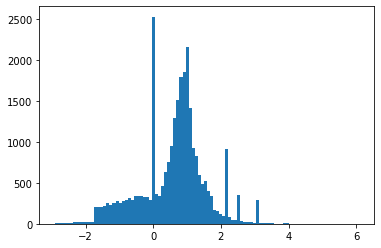

In [30]:
for features,lbl in packed_df.batch(1000).take(1):
  print(features[0].numpy())
  plt.hist(features.numpy().flatten(),bins=100)

In [37]:
n_validation= int(1e3)
n_train=int(1e4)
buffer_size=int(1e4)
batch_size=500
steps_per_epoch=n_train//batch_size
print('Number of Training: {}\nNumber of Validation: {}'.format(n_train,n_validation))
print('Buffer Size: {}\nBatch Size: {}\nSteps Per Epcoch: {}'.format(n_train,n_validation,steps_per_epoch))

Number of Training: 10000
Number of Validation: 1000
Buffer Size: 10000
Batch Size: 1000
Steps Per Epcoch: 20


In [34]:
valid_ds = packed_df.take(n_validation).cache()
train_ds=packed_df.skip(n_validation).take(n_train).cache()

In [35]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [38]:
valid_ds=valid_ds.batch(batch_size)
train_ds=train_ds.shuffle(buffer_size).repeat().batch(batch_size)

In [48]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## Reduce learning rate while training 

In [49]:
lr_rate = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,decay_steps=steps_per_epoch*1000,decay_rate=1,staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_rate)

In [50]:
def callbacks(name):
  return [
          tfdocs.modeling.EpochDots(),
          tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [51]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history